In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from plotnine import *

def calc_mean_sem(data, group_vals, meas, trunc_zero=False):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'std', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_std'] = agg_df[m]['std']
        agg_df[f'{m}_sem'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_sem']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_sem']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

## Control: power pairing vs random pairing

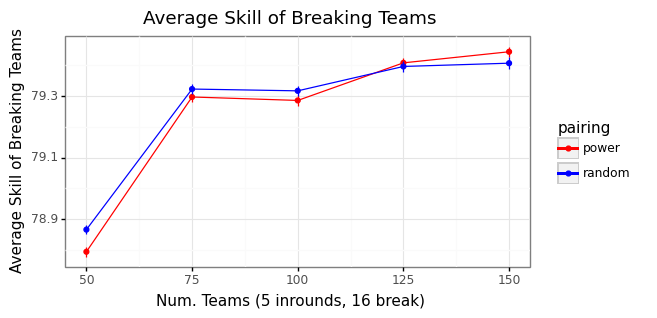

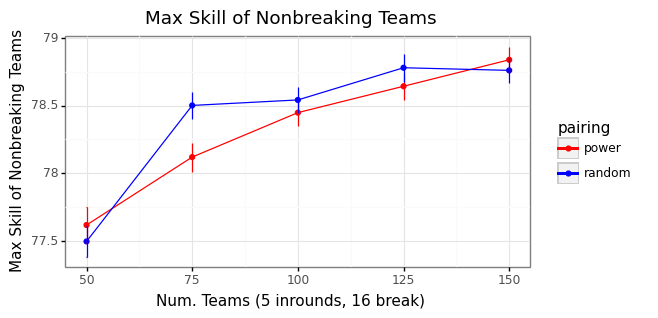

In [29]:
sumstats = pd.read_csv("../sim_data/tapered/2023-01-01/12-09-28/summary.csv")
sumstats = calc_mean_sem(
    sumstats, 
    group_vals=['nteam', 'pairing'], 
    meas=['avg_break_skill', 'max_nonbreaking_skill']
)

for meas, title in zip(
    ['avg_break_skill', 'max_nonbreaking_skill'], 
    ['Average Skill of Breaking Teams', 'Max Skill of Nonbreaking Teams']
):
    g = (
        ggplot(
            sumstats,
            aes(x='nteam', y=f'{meas}_mean', color='pairing')
        ) + 
        geom_line() +
        geom_point() +
        geom_errorbar(
            aes(ymin=f'{meas}_ymin', ymax=f'{meas}_ymax'),
            width=0.01
        )+
        theme_bw() +
        theme(figure_size=(6,3)) + 
        scale_color_manual(['red', 'blue']) + 
        labs(x='Num. Teams (5 inrounds, 16 break)', y=title, title=title)
    )
    print(g)

In [74]:
# Read raw data and calculate num points
raw = pd.read_csv("../sim_data/tapered/2023-01-01/12-09-28/raw.csv")
rcols = [c for c in raw.columns if 'result' in c]
results = raw[rcols]
pts = np.sum(results.values - 1, axis=1)
raw['points'] = pts + np.random.uniform(0, 1, size=raw.shape[0]) # the uniform adds a tiebreaker

# Find rank of teams and check if they broke
raw['rank'] = raw.groupby(['nteam', 'seed', 'pairing'])['points'].rank(ascending=False).astype(int)
raw['break'] = raw['rank'] < 16
raw['true_rank'] = raw.groupby(['nteam', 'seed', 'pairing'])['skill'].rank(ascending=False).astype(int)

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


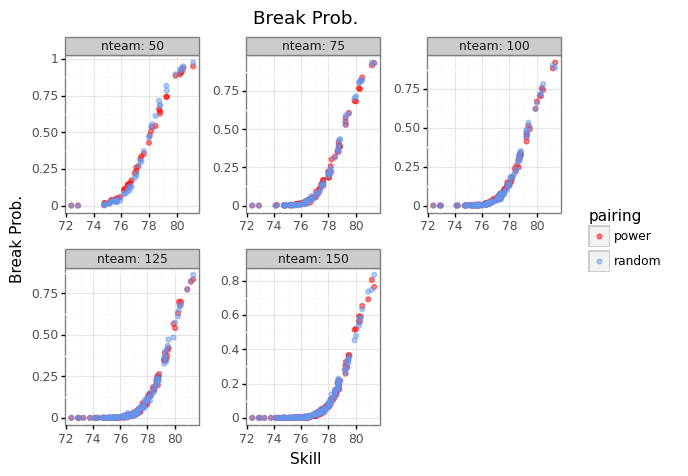

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


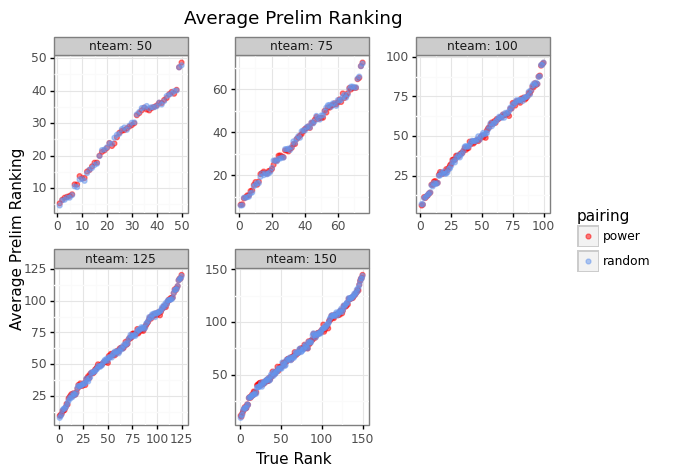

In [98]:
rankstats = calc_mean_sem(
    raw, 
    group_vals=['nteam', 'pairing', 'skill', 'true_rank'], 
    meas=['rank', 'break']
)
xlabels = dict(skill='Skill', true_rank='True Rank')
ylabels = {'break':'Break Prob.', 'rank':'Average Prelim Ranking'}
for x, meas in zip(['skill', 'true_rank'], ['break', 'rank']):
    g = (
        ggplot(rankstats, aes(x=x, y=f'{meas}_mean', color='pairing')) +
        geom_point(alpha=0.5) +
        facet_wrap("~nteam", scales='free', labeller='label_both') + 
        theme_bw() +
        labs(x=xlabels[x], y=ylabels[meas], title=ylabels[meas]) + 
        scale_color_manual(['red', 'cornflowerblue']) +
        theme(subplots_adjust={"wspace":0.35, "hspace":0.35})

    )
    print(g)